In [ ]:
import datetime
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os
import string

Загружаем датасеты

In [48]:
# Загрузка данных о пользователях из CSV файла
user_info = pd.read_csv('user_info.csv')
print('User data has been loaded successfully')

# Загрузка данных о постах из CSV файла
post_info = pd.read_csv('post_info.csv')
print('Post data has been loaded successfully')

# Загрузка данных о взаимодействиях (просмотры) из CSV файла
feed_data = pd.read_csv('feed_data.csv')
feed_data.timestamp = pd.to_datetime(feed_data.timestamp)
print('Data with User-Post interactions has been loaded successfully')

User data has been loaded successfully
Post data has been loaded successfully
Data with User-Post interactions has been loaded successfully


Посмотрим на датасеты

In [49]:
# Датасет с информацией про юзеров
user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [50]:
# Датасет с информацией про посты
post_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [52]:
# Датасет с информацией про взаимодействие юзеров с постами
feed_data.head() 
# target = 1: юзер лайкнул пост, target = 0: юзер посмотрел пост

,timestamp,user_id,post_id,target
0,2021-11-06 09:55:19,128365,3092,0
1,2021-11-06 09:56:25,128365,3179,0
2,2021-11-06 09:58:19,128365,5994,0
3,2021-11-06 09:59:04,128365,4875,0
4,2021-11-06 10:01:48,128365,5982,0


Сгенерим фичи по постам: возьмем тест постам, сделаем TF-IDF, а затем кластеризуем посты по фичам, полученным с помощью TF-IDF

In [77]:
import re
import string
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, OPTICS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

In [56]:
# Removing HTML Tags with BeautifulSoup
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing Markdown Syntax
def remove_markdown_syntax(text):
    # Remove Markdown emphasis (* or **)
    text = re.sub(r'(\*{1,2})(.*?)\1', r'\2', text)
    # Remove Markdown underscores
    text = re.sub(r'(_{1,2})(.*?)\1', r'\2', text)
    # Remove inline code `code`
    text = re.sub(r'`(.*?)`', r'\1', text)
    return text


wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    # Remove HTML tags
    line = remove_html_tags(line)
    # Remove Markdown syntax
    line = remove_markdown_syntax(line)
    # Convert to lowercase
    line = line.lower()
    # Remove punctuation
    line = re.sub(r"[{}]".format(string.punctuation), ' ', line)
    # Remove extra whitespace
    line = re.sub(r'\s+', ' ', line).strip()
    # Lemmatize words
    line = ' '.join([token.lemmatize(word) for word in line.split()])
    return line

tfidf_preprocessed = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing,
    #max_features=100,      # Adjust as needed
    min_df=0.01,               # Уберем элементы, которые встречаются в менее 1 % документов
    max_df=0.99              # Уберем элементы, которые встречаются в более 99 % документов
)

tfidf_data_preprocessed = tfidf_preprocessed.fit_transform(post_info['text'])

tfidf_df = pd.DataFrame(
    tfidf_data_preprocessed.toarray(),
    index=post_info.post_id,
    columns=tfidf_preprocessed.get_feature_names_out()
)

C:\Users\sav\.conda\envs\env_python_3_9_18\lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\sav\AppData\Local\Temp\ipykernel_9244\4258325981.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [57]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7023 entries, 1 to 7319
Columns: 1695 entries, 000 to youve
dtypes: float64(1695)
memory usage: 90.9 MB


Теперь уменьшим размерность полученного датасета с помощью PCA или Truncated SVD (также известный как Latent Semantic Analysis (LSA) в контексте обработки текста). Для уменьшения размерности Truncated SVD лучше всего подходит в контексте TF-IDF, так как он предназначен для работы с разреженными матрицами типа TF-IDF

In [112]:
# Применение TruncatedSVD
n_components = 1100
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_data = svd.fit_transform(tfidf_df)

# Оценка объясненной дисперсии
explained_variance = svd.explained_variance_ratio_.sum()
print(f'Общая объясненная дисперсия с {n_components} компонентами: {explained_variance:.2%}')

Общая объясненная дисперсия с 1100 компонентами: 90.48%


In [113]:
n_components = 1110
pca = PCA(n_components=n_components, random_state=42)
pca.fit(tfidf_df)


PCA(n_components=1110, random_state=42)

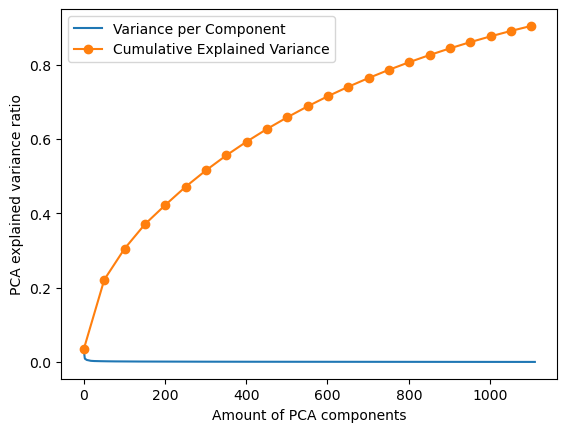

In [114]:
plt.plot(np.arange(1, pca.n_components + 1), 
         pca.explained_variance_ratio_,
         label='Variance per Component')

explained_variances = []

for n in range(1, n_components + 1, 50):
    pca = PCA(n_components=n, random_state=42)
    pca.fit(tfidf_df)
    explained_variances.append(pca.explained_variance_ratio_.sum())

plt.plot(np.arange(1, n_components + 1, 50),
         explained_variances,
         '-o',
         label='Cumulative Explained Variance')
plt.ylabel('PCA explained variance ratio')
plt.xlabel('Amount of PCA components')
plt.legend()
plt.show()

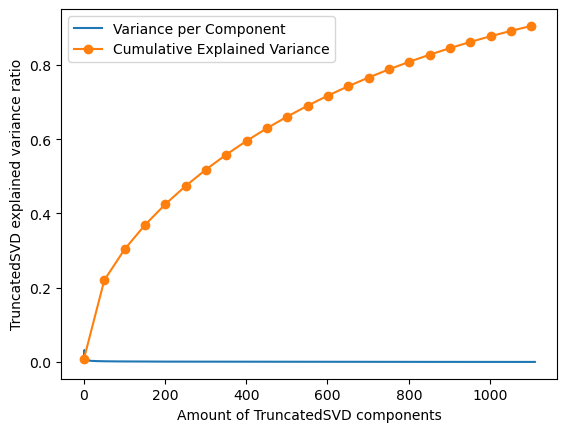

In [116]:
n_components = 1110
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd.fit(tfidf_df)
plt.plot(np.arange(1, svd.n_components + 1), 
         svd.explained_variance_ratio_,
         label='Variance per Component')

explained_variances = []

for n in range(1, n_components + 1, 50):
    svd = TruncatedSVD(n_components=n, random_state=42)
    svd.fit(tfidf_df)
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.plot(np.arange(1, n_components + 1, 50),
         explained_variances,
         '-o',
         label='Cumulative Explained Variance')
plt.ylabel('TruncatedSVD explained variance ratio')
plt.xlabel('Amount of TruncatedSVD components')
plt.legend()
plt.show()

In [119]:
svd_decomp = svd.fit_transform(tfidf_df)

Теперь кластеризуем полученные компоненты

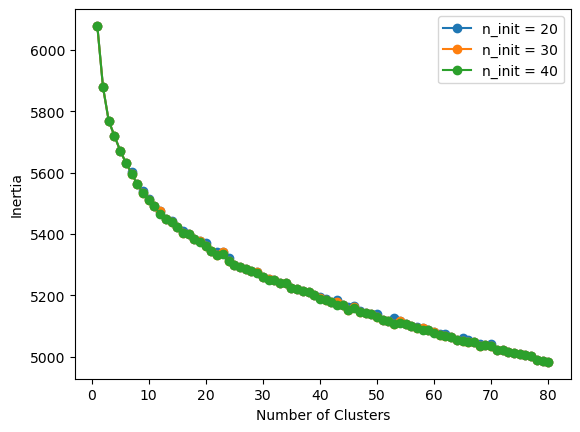

In [137]:
import matplotlib.pyplot as plt

inertias = []
for k in range(1, 81):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 20)
    kmeans.fit(svd_decomp)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 81), inertias, marker='o', label='n_init = 20')

inertias = []
for k in range(1, 81):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 30)
    kmeans.fit(svd_decomp)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 81), inertias, marker='o', label='n_init = 30')

inertias = []
for k in range(1, 81):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 40)
    kmeans.fit(svd_decomp)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 81), inertias, marker='o', label='n_init = 40')

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:56<00:00, 11.89s/it]


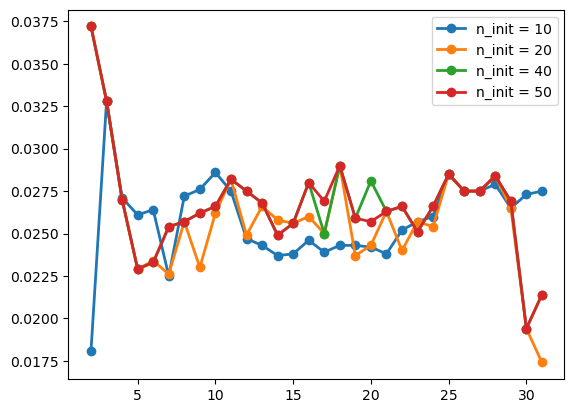

In [142]:
# Оценим качество кластеризации с помощью silhouette_score
from tqdm import tqdm
res_score = []
number_of_clusters = 31
for n_clusters in tqdm(range (2, number_of_clusters+1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(svd_decomp)
    # Оценка качества кластеризации
    res_score.append(silhouette_score(svd_decomp, clusters).round(4))

plt.plot(range (2, number_of_clusters+1), 
         res_score, 
         marker='o',
         linewidth=2, 
         label='n_init = 10')
res_score = []
for n_clusters in tqdm(range (2, number_of_clusters+1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 20)
    clusters = kmeans.fit_predict(svd_decomp)
    # Оценка качества кластеризации
    res_score.append(silhouette_score(svd_decomp, clusters).round(4))

plt.plot(range (2, number_of_clusters+1), 
         res_score, 
         marker='o',
         linewidth=2, 
         label='n_init = 20')
res_score = []
for n_clusters in tqdm(range (2, number_of_clusters+1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 40)
    clusters = kmeans.fit_predict(svd_decomp)
    # Оценка качества кластеризации
    res_score.append(silhouette_score(svd_decomp, clusters).round(4))

plt.plot(range (2, number_of_clusters+1), 
         res_score, 
         marker='o',
         linewidth=2, 
         label='n_init = 40')

res_score = []
for n_clusters in tqdm(range (2, number_of_clusters+1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 50)
    clusters = kmeans.fit_predict(svd_decomp)
    # Оценка качества кластеризации
    res_score.append(silhouette_score(svd_decomp, clusters).round(4))

plt.plot(range (2, number_of_clusters+1), 
         res_score, 
         marker='o',
         linewidth=2, 
         label='n_init = 50')
plt.legend()
plt.show()

C:\Users\sav\.conda\envs\env_python_3_9_18\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


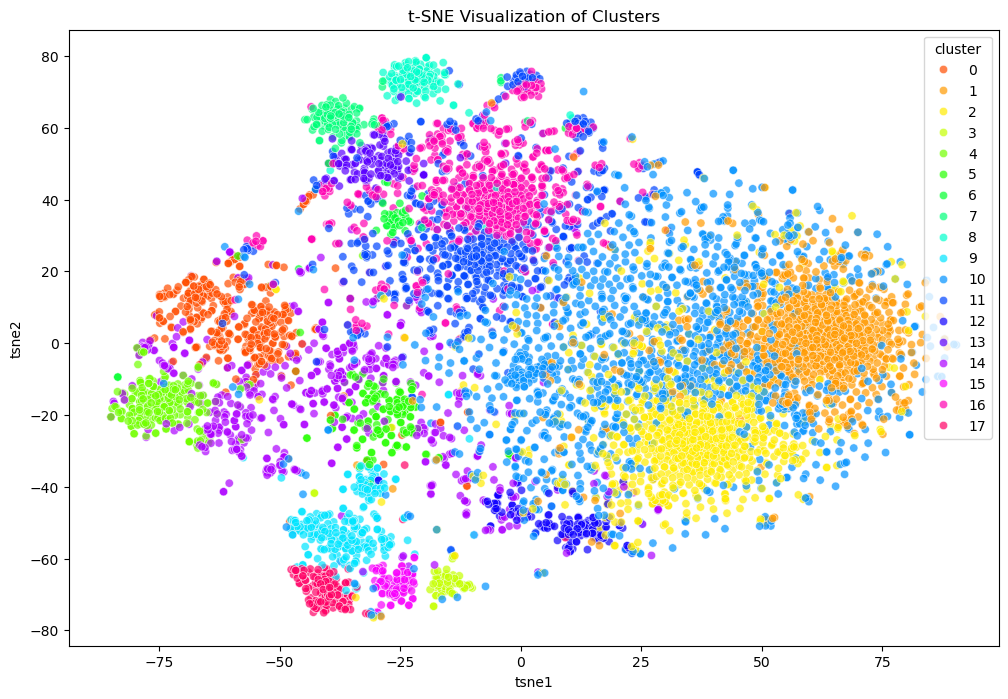

Силуэтный коэффициент: 0.029


In [144]:
kmeans_for_TruncatedSVD = KMeans(n_clusters=18, random_state=42, n_init = 50).fit(svd_decomp)

clusters = kmeans_for_TruncatedSVD.labels_ # this is the array of cluster labels

tsne = TSNE(n_components=2, # используем два измерения
            perplexity=50, 
            n_iter=4000, 
            random_state=42, 
            n_jobs=-1)

tsne_results = tsne.fit_transform(svd_decomp)

tsne_df = pd.DataFrame({
    'tsne1': tsne_results[:, 0],
    'tsne2': tsne_results[:, 1],
    'cluster': clusters  # use array of cluster labels
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne1', y='tsne2',
    hue='cluster',
    palette=sns.color_palette('hsv', n_colors=len(set(clusters))),
    data=tsne_df,
    legend='full',
    alpha=0.7
)
plt.title('t-SNE Visualization of Clusters')
plt.show()


# Оценка качества кластеризации
score = silhouette_score(svd_decomp, clusters)
print(f'Силуэтный коэффициент: {score:.3f}')

In [146]:
# Делаем в датасете с постами колонку 'TextCluster' с наименованием кластера, 
# к которому больше всего относится текст поста и 
# также делаем колонки 'DistanceToClusterN={n}' с расстоянием до других постов

post_info['TextCluster'] = kmeans_for_TruncatedSVD.labels_

dists_columns = [f'DistanceToClusterN={n}' for n in range(1,19)]

dists_df = pd.DataFrame(data=kmeans_for_TruncatedSVD.transform(svd_decomp), columns = dists_columns) # считаем расстояние каждого поста до центра кластера


In [155]:
len(kmeans_for_TruncatedSVD.labels_)

7023

In [158]:
np.arange(0,19,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

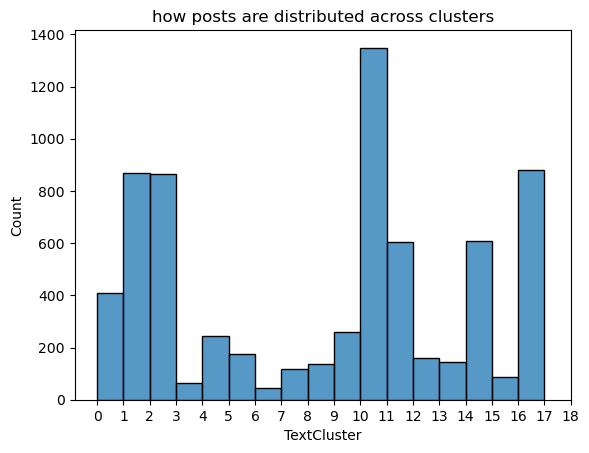

In [159]:
sns.histplot(data=post_info, x = 'TextCluster')
plt.title('how posts are distributed across clusters')
plt.xticks(np.arange(0,19,1))
plt.show()

In [148]:
# Сформируем еше несколько фич для датасета с постами:

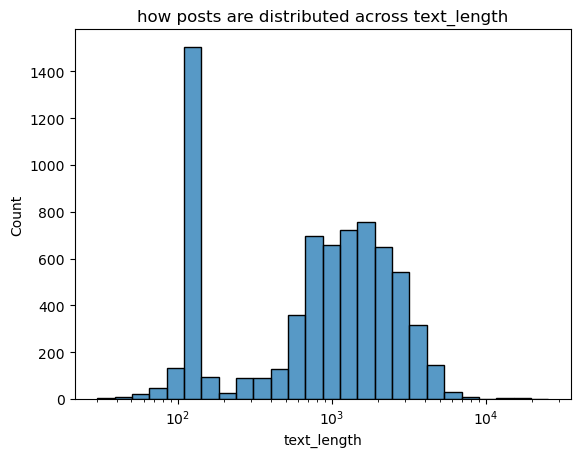

In [161]:
#введем дополнительные фичи: длина текста
post_info['text_length'] = post_info['text'].str.len()

sns.histplot(data=post_info, x = 'text_length',log_scale=True)
#plt.xticks(rotation=80)
plt.title('how posts are distributed across text_length')
plt.show()

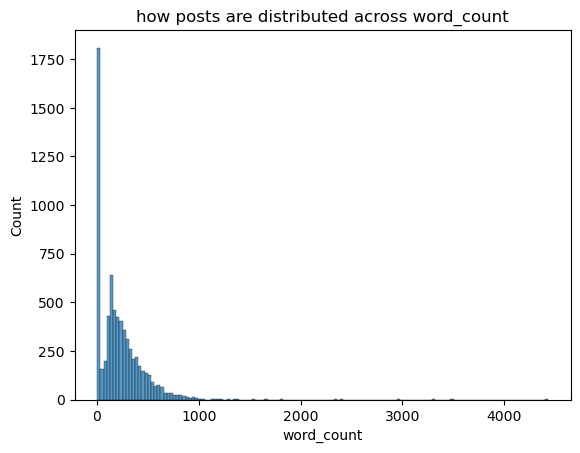

In [170]:
#введем дополнительные фичи: количество слов
post_info['word_count'] = post_info['text'].str.split().str.len()

sns.histplot(data=post_info, x = 'word_count')
#plt.xticks(rotation=80)
plt.title('how posts are distributed across word_count')
plt.show()

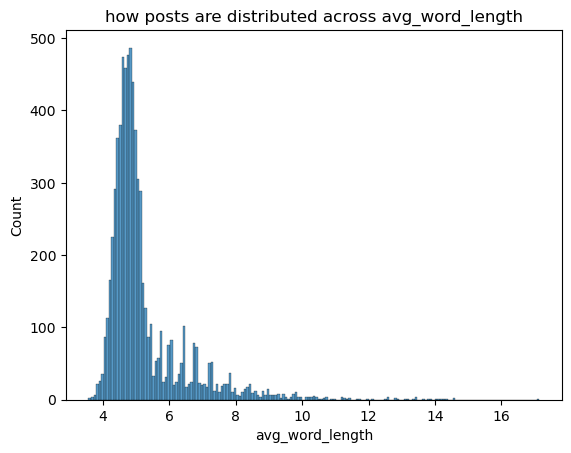

In [167]:
#средняя сдлина слова
post_info['avg_word_length'] = post_info['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))

sns.histplot(data=post_info, x = 'avg_word_length')
#plt.xticks(rotation=80)
plt.title('how posts are distributed across avg_word_length')
plt.show()

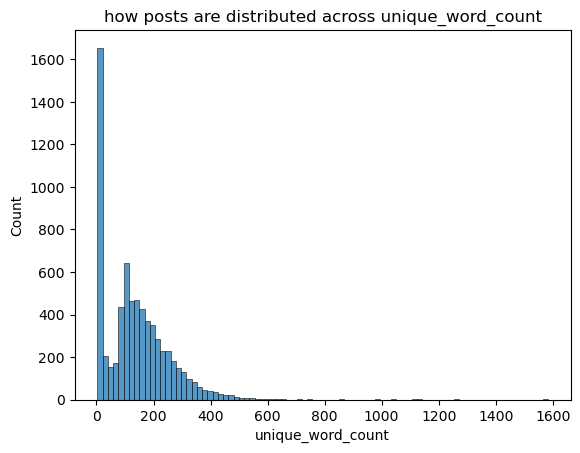

In [179]:
# количество уникальных слов:
post_info['unique_word_count'] = post_info['text'].apply(lambda x: len(set(x.split())))

sns.histplot(data=post_info, x = 'unique_word_count')
#plt.xticks(rotation=80)
plt.title('how posts are distributed across unique_word_count')
plt.show()

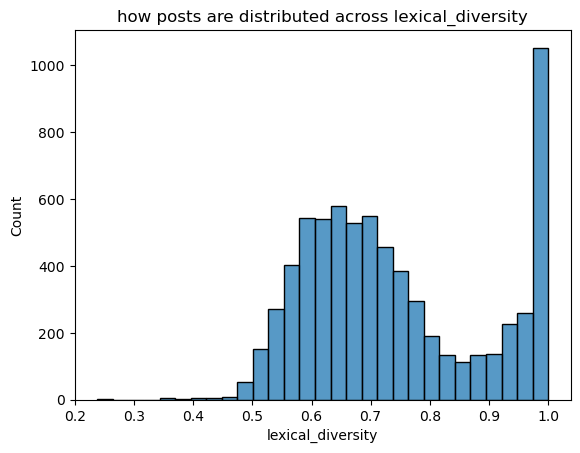

In [180]:
# Отношение количества уникальных слов к общему количеству слов: лексическое разнообразие
post_info['lexical_diversity'] = post_info['unique_word_count'] / post_info['word_count']

sns.histplot(data=post_info, x = 'lexical_diversity')
#plt.xticks(rotation=80)
plt.title('how posts are distributed across lexical_diversity')
plt.show()

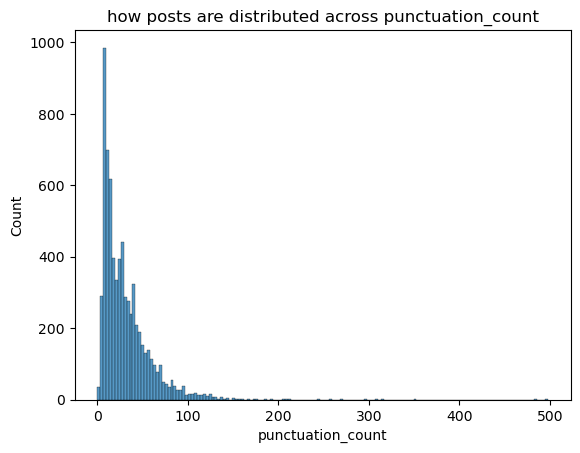

In [181]:
# КОличесвто знаков препинания:
import string
post_info['punctuation_count'] = post_info['text'].apply(lambda x: sum(x.count(p) for p in string.punctuation))

sns.histplot(data=post_info, x = 'punctuation_count')
#plt.xticks(rotation=80)
plt.title('how posts are distributed across punctuation_count')
plt.show()

Соединяем информацию по кластерам постов с датасетом с постами

In [182]:
clusterized_post_info = pd.concat((post_info, dists_df), axis = 1)

In [ ]:
# Теперь посмотрим на датасет с юзерами

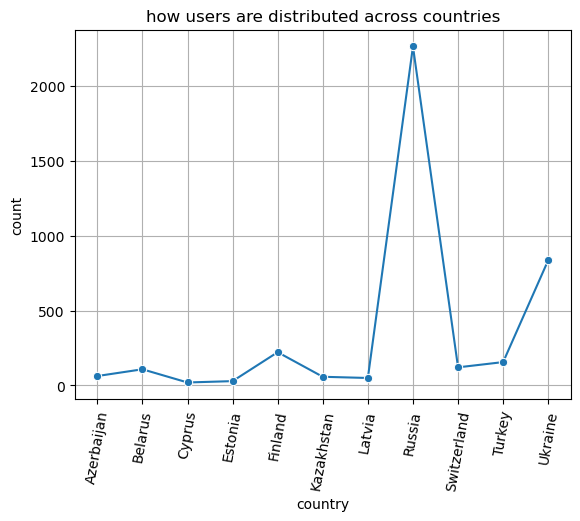

In [185]:
country_city_data = user_info.groupby(['country'])['city'].nunique().reset_index()
sns.lineplot(data=country_city_data, x = 'country', y = 'city', marker = 'o')
plt.xticks(rotation=80)
plt.ylabel('count')
plt.grid('True')
plt.title('how users are distributed across countries')
plt.show()

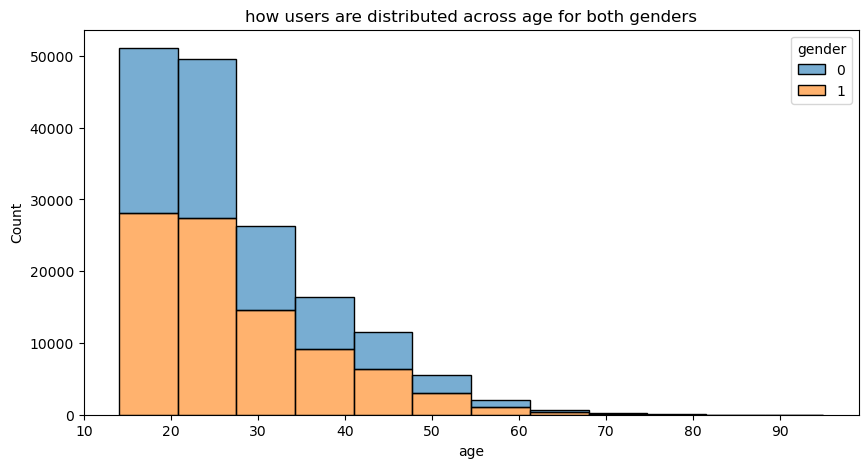

In [190]:
plt.figure(figsize=(10,5))
sns.histplot(data=user_info, x='age', hue='gender', bins=12, multiple='stack', alpha = 0.6)
plt.title('how users are distributed across age for both genders')
plt.show()

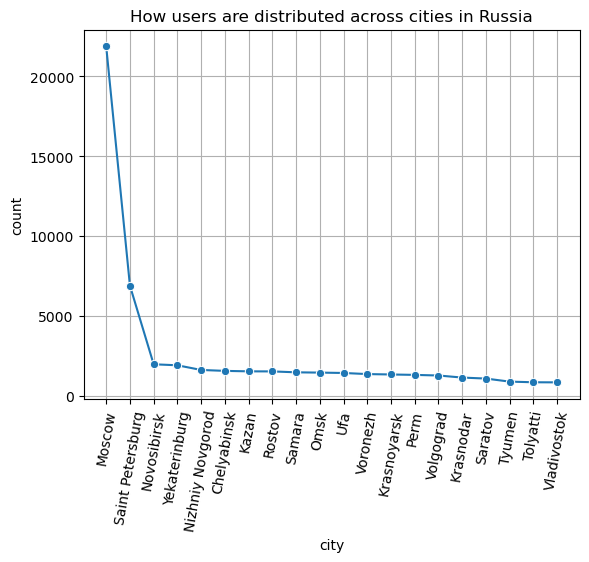

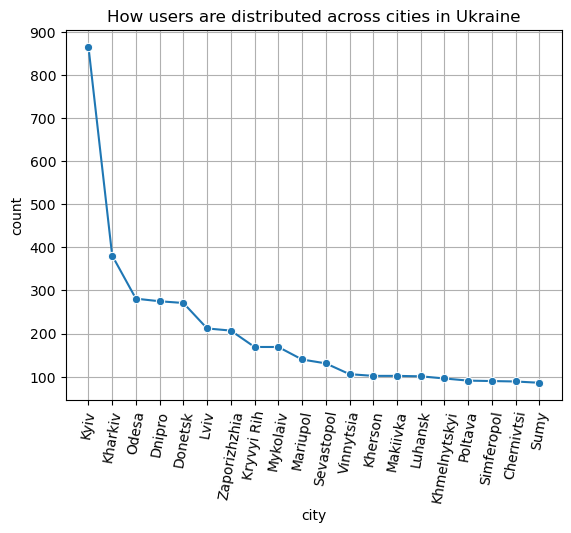

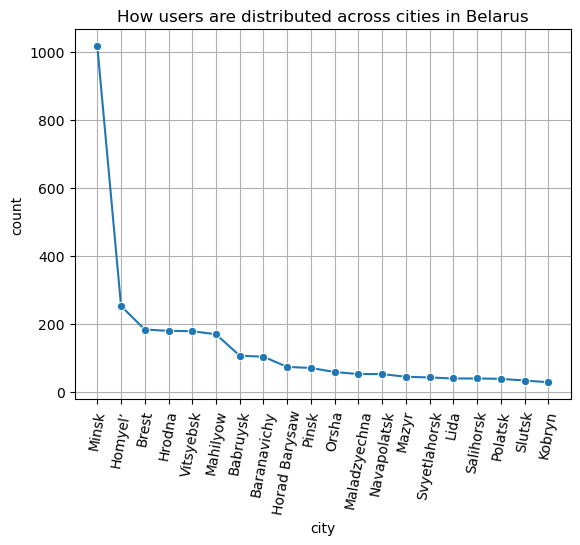

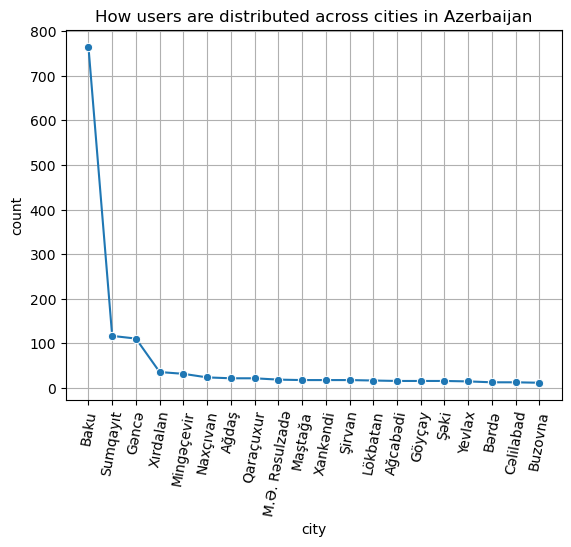

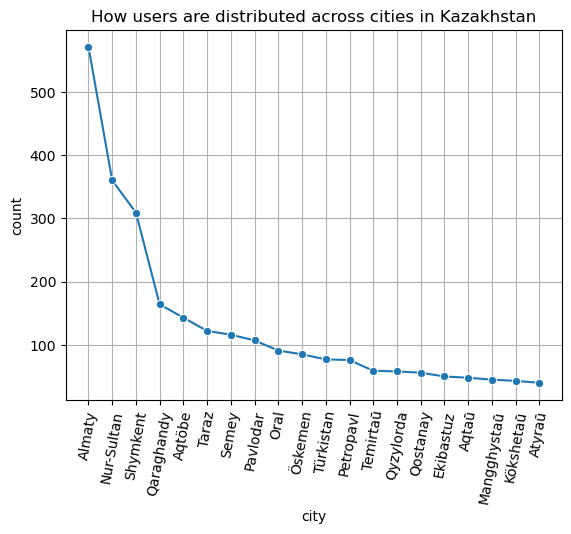

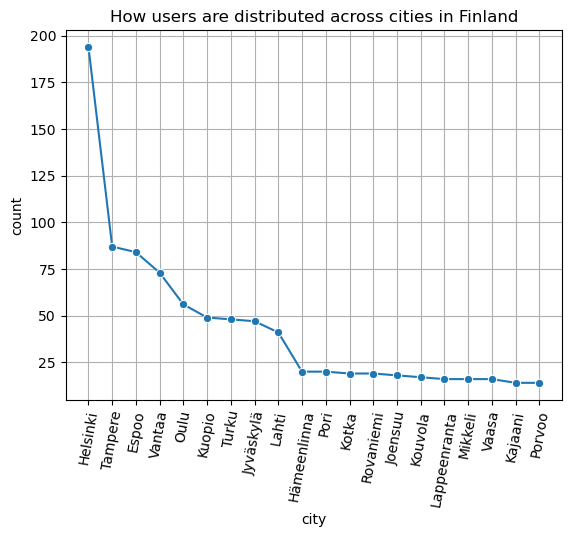

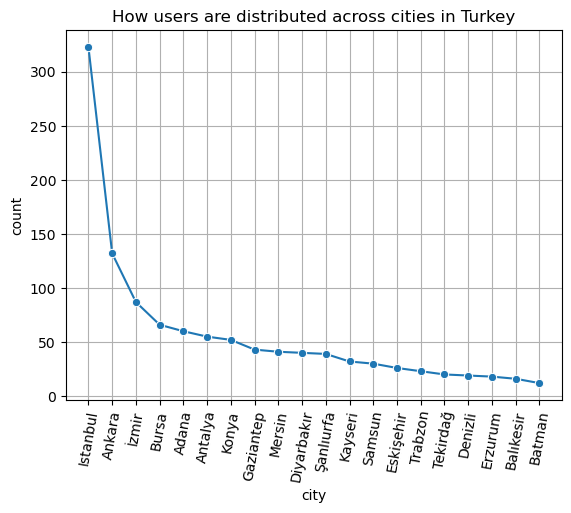

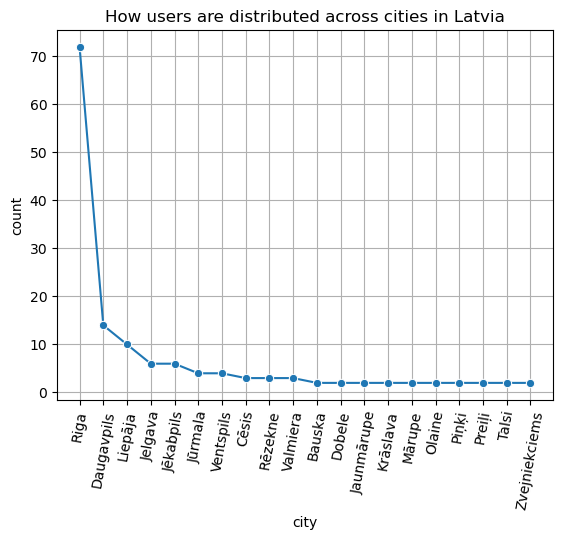

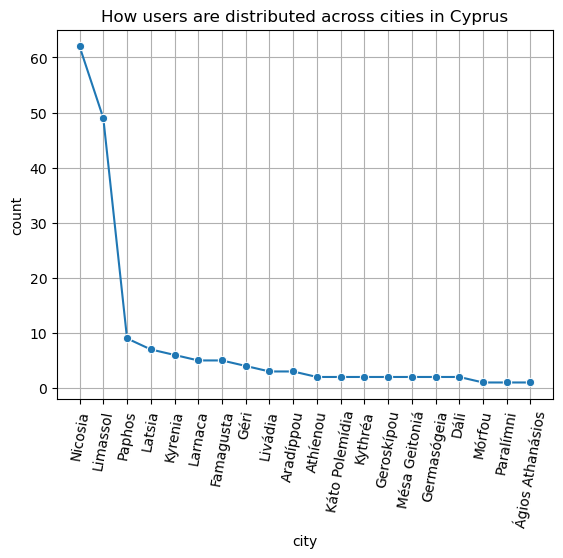

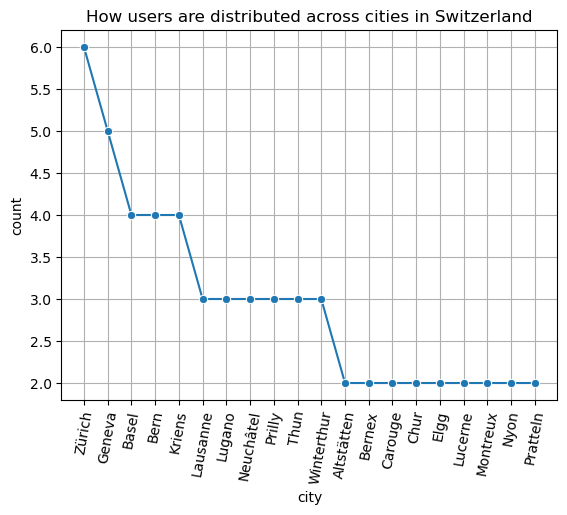

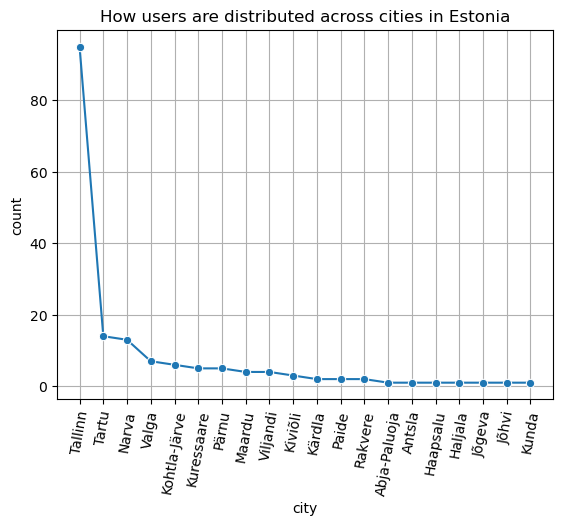

In [193]:
for country in list(user_info.country.unique()):
    userCount_to_city = user_info[user_info.country == country].groupby('city').size().nlargest(20).reset_index()
    userCount_to_city.columns = ['city', 'count']
    sns.lineplot(data= userCount_to_city, x='city', y='count', marker = 'o')
    plt.xticks(rotation=80)
    plt.title('How users are distributed across cities in ' + country)
    plt.grid('True')
    plt.show()

In [194]:
# Теперь соединяем таблицы с взаимодействиями, постами и юзерами

df = pd.merge(left = feed_data, right = clusterized_post_info, on='post_id', how='left')
df = pd.merge(left = df, right = user_info, on='user_id', how='left')
df.head(1)

,timestamp,user_id,post_id,target,text,topic,TextCluster,text_length,word_count,avg_word_length,...,DistanceToClusterN=16,DistanceToClusterN=17,DistanceToClusterN=18,gender,age,country,city,exp_group,os,source
0,2021-11-06 09:55:19,128365,3092,0,ALERT: Big Tech commits MEDICAL TREASON by cen...,covid,8,139,18,6.777778,...,1.086049,1.02519,1.086497,1,29,Russia,Yarkovo,4,Android,organic


In [195]:
# теперь timestamp: сгенерим фичи из времени
import datetime

df['hour'] = df['timestamp'].dt.hour # Добавим час дня
df['month'] = df['timestamp'].dt.month # Добавим месяц
df['day_of_week'] = df['timestamp'].dt.dayofweek # Добавим день недели

def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(get_time_of_day) # Добавим деление дня на утро, день, вечер, ночь


# Добавим цикличность в временную шкалу: Модели лучше улавливают 
# циклические зависимости, когда время представлено таким образом.
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


In [196]:
# Удалим колонку с текстом, а 'user_id' и 'post_id' переведем в индекс
df = df.drop(columns = [
    #'timestamp',
    
    'text'
])

df = df.set_index(['user_id', 'post_id'])
df.head(1)

,,timestamp,target,topic,TextCluster,text_length,word_count,avg_word_length,unique_word_count,lexical_diversity,punctuation_count,...,country,city,exp_group,os,source,hour,month,day_of_week,time_of_day,hour_cos
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
128365,3092,2021-11-06 09:55:19,0,covid,8,139,18,6.777778,17,0.944444,7,...,Russia,Yarkovo,4,Android,organic,9,11,5,morning,-0.707107


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000000 entries, (128365, 3092) to (100626, 6420)
Data columns (total 40 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp              datetime64[ns]
 1   target                 int64         
 2   topic                  object        
 3   TextCluster            int32         
 4   text_length            int64         
 5   word_count             int64         
 6   avg_word_length        float64       
 7   unique_word_count      int64         
 8   lexical_diversity      float64       
 9   punctuation_count      int64         
 10  DistanceToClusterN=1   float64       
 11  DistanceToClusterN=2   float64       
 12  DistanceToClusterN=3   float64       
 13  DistanceToClusterN=4   float64       
 14  DistanceToClusterN=5   float64       
 15  DistanceToClusterN=6   float64       
 16  DistanceToClusterN=7   float64       
 17  DistanceToClusterN=8   float64       
 18  D

In [ ]:
# Оптимизируем память под датасет

In [198]:
categorical_columns = df.select_dtypes(include = ['object']).columns.tolist()

for col in categorical_columns:
    df[col] = df[col].astype('category')

    
numeric_cols = list(df.select_dtypes(exclude=['object', 'category']).columns)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000000 entries, (128365, 3092) to (100626, 6420)
Data columns (total 40 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   timestamp              datetime64[ns]
 1   target                 int64         
 2   topic                  category      
 3   TextCluster            int32         
 4   text_length            int64         
 5   word_count             int64         
 6   avg_word_length        float64       
 7   unique_word_count      int64         
 8   lexical_diversity      float64       
 9   punctuation_count      int64         
 10  DistanceToClusterN=1   float64       
 11  DistanceToClusterN=2   float64       
 12  DistanceToClusterN=3   float64       
 13  DistanceToClusterN=4   float64       
 14  DistanceToClusterN=5   float64       
 15  DistanceToClusterN=6   float64       
 16  DistanceToClusterN=7   float64       
 17  DistanceToClusterN=8   float64       
 18  D

In [203]:
def reduce_memory_usage(df):
    """
    Функция для оптимизации типа значений числовых колонок DataFrame.
    Она уменьшает объем памяти, занимаемый DataFrame, путем преобразования типов данных в более компактные.
    
    Parameters:
    df (pd.DataFrame): DataFrame для оптимизации.
    
    Returns:
    pd.DataFrame: Оптимизированный DataFrame с уменьшенным объемом памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Начальный объем памяти: {start_mem:.2f} Мб')
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type == 'int64' or col_type == 'int32':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)

        elif col_type == 'float64' or col_type == 'float32':
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Конечный объем памяти после оптимизации: {end_mem:.2f} Мб')
    print(f'Объем памяти уменьшен на {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df



df = reduce_memory_usage(df)

Начальный объем памяти: 1135.94 Мб
Конечный объем памяти после оптимизации: 735.40 Мб
Объем памяти уменьшен на 35.3%


In [204]:
# делим трейн и тест по дате 2021-12-20
df_train = df[df.timestamp < '2021-12-18']
df_test = df[df.timestamp >= '2021-12-18']

df_train = df_train.drop(columns = 'timestamp')
df_test = df_test.drop(columns = 'timestamp')

X_train, X_test = df_train.drop(columns = 'target'), df_test.drop(columns = 'target')
y_train, y_test = df_train['target'], df_test['target']

y_train.shape, y_test.shape, y_test.shape[0] / (y_train.shape[0]+y_test.shape[0])

((8677959,), (1322041,), 0.1322041)

In [205]:
y_train.mean()

0.11700389457935904

In [206]:
y_test.mean()

0.13947600717375633

In [208]:
X_train.select_dtypes(include = 'category').columns.tolist()

['topic', 'country', 'city', 'os', 'source', 'time_of_day']

In [209]:
import datetime
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import psutil
import os
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, make_scorer, classification_report,confusion_matrix, average_precision_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
###########################################################
#Используем LGBMClassifier (sklearn-совместимый интерфейс)#
###########################################################

In [210]:
import os
import psutil
import time
# Set the number of threads for BLAS operations
os.environ['OMP_NUM_THREADS'] = '8'
number_of_jobs = -1

lgb_model = lgb.LGBMClassifier(
    objective='binary',  # Задача бинарной классификации
    metric='auc',  # Метрика AUC 'auc',
    #boosting_type='gbdt',    
    learning_rate=0.09,
    #num_leaves=204,  # Количество листьев дерева
    #max_depth=13,  # ограничения глубины
    #min_data_in_leaf = 100,
    #min_child_samples=45,
    random_state=42,
    n_estimators=2000,  # Количество деревьев
    #max_bin=255,  # Увеличили количество бинов для категориальных признаков
    n_jobs=number_of_jobs,
    is_unbalance=True,
    #reg_lambda=4.252715181203589e-08,
    #reg_alpha=0.000634314773011794
)

# Обучаем модель
lgb_model.fit(X_train, y_train,
              #sample_weight=sample_weights,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
              callbacks=[early_stopping(stopping_rounds=50)])

# Предсказание вероятностей на тестовой выборке

print(f'Train AUC: {roc_auc_score(y_train, lgb_model.predict_proba(X_train)[:,1])}')
print(f'Test AUC: {roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:,1])}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 1015355, number of negative: 7662604
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.419855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7417
[LightGBM] [Info] Number of data points in the train set: 8677959, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117004 -> initscore=-2.021114
[LightGBM] [Info] Start training from score -2.021114
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[862]	training's auc: 0.73455	valid_1's auc: 0.674179
Train AUC: 0.7345502523625764
Test AUC: 0.6741786338008

In [211]:
import joblib
filename = 'model_by_pickle.pkl'
pickle.dump(lgb_model, open(filename, 'wb'))

filename = 'model_by_booster_.txt'
lgb_model.booster_.save_model(filename)

model_filename = 'model_by_joblib.pkl'
joblib.dump(lgb_model, model_filename)

['model_by_joblib.pkl']

In [212]:
# Получаем важность признаков из модели 

feature_importances = lgb_model.feature_importances_

# Получаем имена признаков после трансформации (если были изменения)
feature_names = lgb_model.feature_name_

# Создаём DataFrame для ранжирования важности признаков
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортируем по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Выводим важные признаки
feature_importance_df

,Feature,Importance
29,city,16353
27,age,1218
20,DistanceToClusterN=13,477
4,avg_word_length,464
12,DistanceToClusterN=5,421
13,DistanceToClusterN=6,403
9,DistanceToClusterN=2,378
21,DistanceToClusterN=14,376
22,DistanceToClusterN=15,349
8,DistanceToClusterN=1,342


In [ ]:
##############################
##Используем теперь CatBoost##
##############################

In [18]:
from catboost import CatBoostClassifier

In [213]:
!pip install catboost[gpu]

In [216]:
catboost = CatBoostClassifier(iterations=1000,
                              #learning_rate=1,
                              #depth=2,
                              eval_metric='AUC',  # Метрика AUC
                              random_seed=100,
                              auto_class_weights='Balanced',
                              verbose=50,  # Вывод прогресса обучения каждые 100 итераций
                              thread_count=-1,  # Использование всех доступных процессоров
                              early_stopping_rounds=20)

catboost.fit(X_train, 
             y_train,
             categorical_columns,
             eval_set=(X_test, y_test),
             use_best_model=True)

print(f'Train AUC: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:,1])}')
print(f'Test AUC: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:,1])}')

Learning rate set to 0.297645
0:	test: 0.6164526	best: 0.6164526 (0)	total: 3.62s	remaining: 1h 13s
50:	test: 0.6617765	best: 0.6617765 (50)	total: 2m 56s	remaining: 54m 48s
100:	test: 0.6692280	best: 0.6692280 (100)	total: 5m 50s	remaining: 52m 4s
150:	test: 0.6743466	best: 0.6743466 (150)	total: 8m 45s	remaining: 49m 14s
200:	test: 0.6778579	best: 0.6778579 (200)	total: 11m 38s	remaining: 46m 15s
250:	test: 0.6804860	best: 0.6804860 (250)	total: 14m 33s	remaining: 43m 28s
300:	test: 0.6825120	best: 0.6825120 (300)	total: 17m 31s	remaining: 40m 40s
350:	test: 0.6840054	best: 0.6840054 (350)	total: 20m 28s	remaining: 37m 51s
400:	test: 0.6855051	best: 0.6855051 (400)	total: 23m 23s	remaining: 34m 56s
450:	test: 0.6864605	best: 0.6864605 (450)	total: 26m 20s	remaining: 32m 4s
500:	test: 0.6872936	best: 0.6873012 (499)	total: 29m 17s	remaining: 29m 10s
550:	test: 0.6881395	best: 0.6881395 (550)	total: 32m 17s	remaining: 26m 18s
600:	test: 0.6887917	best: 0.6887917 (600)	total: 35m 16s	re

In [ ]:
bestTest = 0.6915066442
bestIteration = 999

Train AUC: 0.7240292442028764
Test AUC: 0.6915066442250561

In [26]:
catboost = CatBoostClassifier(iterations=400,
                              learning_rate=0.5,
                              depth=2,
                              eval_metric='AUC',  # Метрика AUC
                              random_seed=100,
                              auto_class_weights='Balanced',
                              verbose=100,  # Вывод прогресса обучения каждые 100 итераций
                              thread_count=-1,  # Использование всех доступных процессоров
                              early_stopping_rounds=50,
                              task_type='GPU'  # Указание на использование GPU
                             )

catboost.fit(X_train, 
             y_train,
             categorical_columns,
             eval_set=(X_test, y_test),
             use_best_model=True)

print(f'Train AUC: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:,1])}')
print(f'Test AUC: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:,1])}')

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5759864	best: 0.5759864 (0)	total: 401ms	remaining: 2m 39s
100:	test: 0.6478279	best: 0.6478279 (100)	total: 39.5s	remaining: 1m 56s
200:	test: 0.6518659	best: 0.6518659 (200)	total: 1m 17s	remaining: 1m 16s
300:	test: 0.6546864	best: 0.6546864 (300)	total: 1m 55s	remaining: 37.9s
399:	test: 0.6556119	best: 0.6556119 (399)	total: 2m 32s	remaining: 0us
bestTest = 0.6556119025
bestIteration = 399
Train AUC: 0.6810486157764403
Test AUC: 0.6556119115575743


In [217]:
# Сохраняем модель catboost
catboost.save_model(
    'catboost_model',
    format="cbm"
)

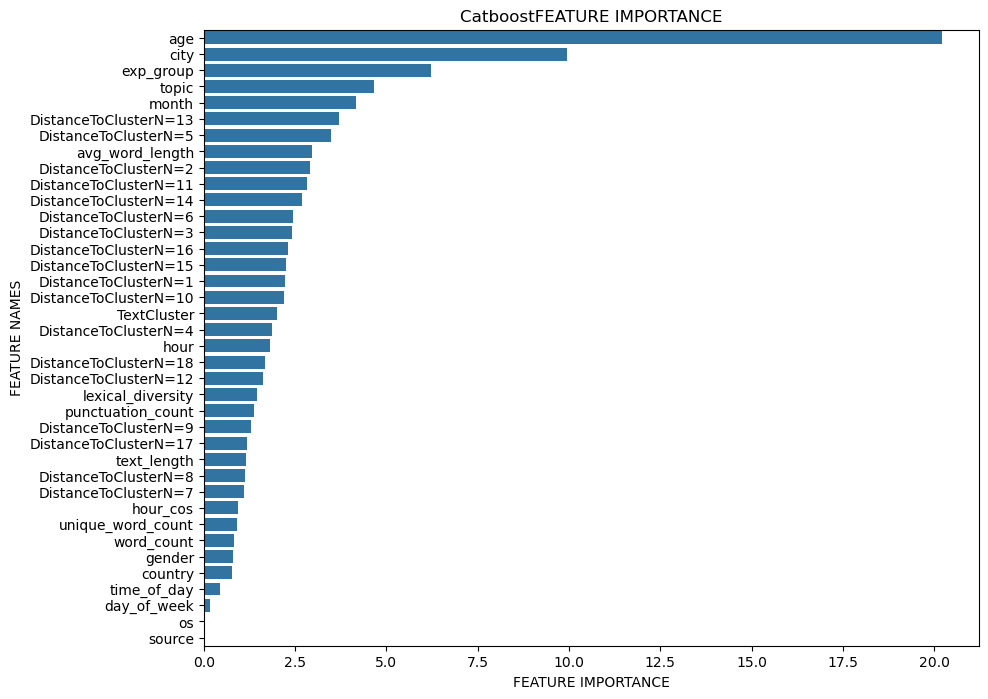

In [218]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')

In [ ]:
##############################
##Используем теперь XGBoost##
##############################

In [220]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [224]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    device='cuda',  # Указание использования GPU
    learning_rate=0.05,
    max_depth=8,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    random_state=42,
    gamma=0.05,
    reg_alpha=0.5,
    reg_lambda=0.5,
    early_stopping_rounds=50,  # критерий раннего останова
    enable_categorical=True, # используем встроенную обработку категориальных переменных
    n_jobs=-1  # Использование всех потоков ЦП
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

# Предсказание и оценка
from sklearn.metrics import roc_auc_score

y_pred_train = xgb_model.predict_proba(X_train)[:, 1]
y_pred_test = xgb_model.predict_proba(X_test)[:, 1]

print(f'Train AUC XGBClassifier: {roc_auc_score(y_train, y_pred_train)}')
print(f'Test AUC XGBClassifier: {roc_auc_score(y_test, y_pred_test)}')



[01:47:08] WARNING: D:\bld\xgboost-split_1660208973102\work\src\learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.58280
[50]	validation_0-auc:0.59332
[100]	validation_0-auc:0.61483
[150]	validation_0-auc:0.62931
[200]	validation_0-auc:0.63544
[250]	validation_0-auc:0.63959
[300]	validation_0-auc:0.64171
[350]	validation_0-auc:0.64349
[400]	validation_0-auc:0.64568
[450]	validation_0-auc:0.64702
[500]	validation_0-auc:0.64865
[550]	validation_0-auc:0.65035
[600]	validation_0-auc:0.65199
[650]	validation_0-auc:0.65267
[700]	validation_0-auc:0.65346
[750]	validation_0-auc:0.65433
[800]	validation_0-auc:0.65524
[850]	validation_0-auc:0.65570
[900]	validation_0-auc:0.65592
[950]	validation_0-a

In [222]:
print(f'Train AUC: {roc_auc_score(y_train, xgb_model.predict_proba(X_train)[:,1])}')
print(f'Test AUC: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])}')

Train AUC: 0.6228924013765913
Test AUC: 0.6007225130490839


In [ ]:
Train AUC: 0.6228924013765913
Test AUC: 0.6007225130490839